In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

In [2]:
"""Mixture of Gaussians.

Perform inference with Metropolis-Hastings. It utterly fails. This is
because we are proposing a sample in a high-dimensional space. The
acceptance ratio is so small that it is unlikely we'll ever accept a
proposed sample. A Gibbs-like extension ("MH within Gibbs"), which
does a separate MH in each dimension, may succeed.

References
----------
http://edwardlib.org/tutorials/unsupervised
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import six
import tensorflow as tf

from edward.models import \
    Categorical, Dirichlet, Empirical, InverseGamma, Normal
from edward.models import Beta,Mixture,MultivariateNormalDiag,PointMass
from scipy.stats import norm


def build_toy_dataset(N):
  pi = np.array([0.4, 0.6])
  mus = [[1, 1], [-1, -1]]
  stds = [[0.1, 0.1], [0.1, 0.1]]
  x = np.zeros((N, 2))
  for n in range(N):
    k = np.argmax(np.random.multinomial(1, pi))
    x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))

  return x


N = 500  # number of data points
K = 2  # number of components
D = 2  # dimensionality of data
#ed.set_seed(42)

# DATA
x_data = build_toy_dataset(N)

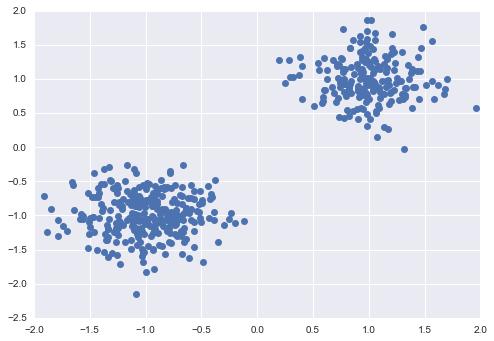

In [3]:
plt.plot(x_data[:,0],x_data[:,1],'o')

In [39]:

# MODEL
pi = Dirichlet(concentration=tf.constant([1.0] * K))
mu = Normal(loc=tf.zeros([K, D]), scale=tf.ones([K, D]))
sigma = InverseGamma(concentration=tf.ones([K, D]), rate=tf.ones([K, D]))
c = Categorical(logits=tf.tile(tf.reshape(ed.logit(pi), [1, K]), [N, 1]))
x = Normal(loc=tf.gather(mu, c), scale=tf.gather(sigma, c))

# INFERENCE
T = 5000
qpi = Empirical(params=tf.Variable(tf.ones([T, K]) / K))
qmu = Empirical(params=tf.Variable(tf.zeros([T, K, D])))
qsigma = Empirical(params=tf.Variable(tf.ones([T, K, D])))
qc = Empirical(params=tf.Variable(tf.zeros([T, N], dtype=tf.int32)))

gpi = Dirichlet(concentration=tf.constant([1.4, 1.6]))
gmu = Normal(loc=tf.constant([[1.0, 1.0], [-1.0, -1.0]]),
             scale=tf.constant([[0.5, 0.5], [0.5, 0.5]]))
gsigma = InverseGamma(concentration=tf.constant([[1.1, 1.1], [1.1, 1.1]]),
                      rate=tf.constant([[1.0, 1.0], [1.0, 1.0]]))
gc = Categorical(logits=tf.zeros([N, K]))

inference = ed.MetropolisHastings(
    latent_vars={pi: qpi, mu: qmu, sigma: qsigma, c: qc},
    proposal_vars={pi: gpi, mu: gmu, sigma: gsigma, c: gc},
    data={x: x_data})

inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)

  t = info_dict['t']
  if t == 1 or t % inference.n_print == 0:
    qpi_mean, qmu_mean = sess.run([qpi.mean(), qmu.mean()])
    print("")
    print("Inferred membership probabilities:")
    print(qpi_mean)
    print("Inferred cluster means:")
    print(qmu_mean)


   1/5000 [  0%]                                ETA: 10883s | Acceptance Rate: nan
Inferred membership probabilities:
[ 0.5  0.5]
Inferred cluster means:
[[ 0.  0.]
 [ 0.  0.]]
  50/5000 [  1%]                                ETA: 246s | Acceptance Rate: 0.000
Inferred membership probabilities:
[ 0.5  0.5]
Inferred cluster means:
[[ 0.  0.]
 [ 0.  0.]]
 100/5000 [  2%]                                ETA: 138s | Acceptance Rate: 0.000
Inferred membership probabilities:
[ 0.5  0.5]
Inferred cluster means:
[[ 0.  0.]
 [ 0.  0.]]
 150/5000 [  3%]                                ETA: 102s | Acceptance Rate: 0.000
Inferred membership probabilities:
[ 0.5  0.5]
Inferred cluster means:
[[ 0.  0.]
 [ 0.  0.]]
 200/5000 [  4%] █                              ETA: 84s | Acceptance Rate: 0.000 
Inferred membership probabilities:
[ 0.5  0.5]
Inferred cluster means:
[[ 0.  0.]
 [ 0.  0.]]
 250/5000 [  5%] █                              ETA: 75s | Acceptance Rate: 0.000
Inferred membership probabilities

In [5]:
qpi.params.eval()[1,:]

array([ 0.5,  0.5], dtype=float32)

In [144]:
# MODEL
pi = Dirichlet(concentration=tf.constant([1.0] * K))
mu = Normal(loc=tf.zeros([K, D]), scale=tf.ones([K, D]))
sigma = InverseGamma(concentration=tf.ones([K, D]), rate=tf.ones([K, D]))
c = Categorical(logits=tf.tile(tf.reshape(ed.logit(pi), [1, K]), [N, 1]))
x = Normal(loc=tf.gather(mu, c), scale=tf.gather(sigma, c))


In [145]:
# INFERENCE
T = 15000
qpi = Empirical(params=tf.Variable(tf.ones([T, K]) / K))
qmu = Empirical(params=tf.Variable(tf.zeros([T, K, D])))
qsigma = Empirical(params=tf.Variable(tf.ones([T, K, D])))
#qc = Empirical(params=tf.Variable(tf.zeros([T, N], dtype=tf.int32)))


In [146]:
'''
ds = tf.contrib.distributions

gpi = ed.models.TransformedDistribution(
  distribution = ds.Normal(loc=pi, scale=[0.01,0.01]),
  bijector=ds.bijectors.Affine(
    scale_identity_multiplier=1.0),
    #scale_identity_multiplier=1/tf.reduce_sum(pi)),
  name="ProbWithSmallNoise")
'''

gpi = Dirichlet(concentration=tf.constant([1.0] * K))

gmu = Normal(loc=mu,
             scale=tf.constant([0.01,0.01]))
gsigma = Normal(loc = sigma,
                scale = tf.constant([0.01,0.01]))
#gc = Categorical(logits=tf.zeros([N, K]))


In [147]:
inference = ed.MetropolisHastings(
    latent_vars={pi: qpi, mu: qmu, sigma: qsigma},
    proposal_vars={pi: gpi, mu: gmu, sigma: gsigma},
    data={x: x_data})


In [148]:
inference.run()

15000/15000 [100%] ██████████████████████████████ Elapsed: 11s | Acceptance Rate: 0.158


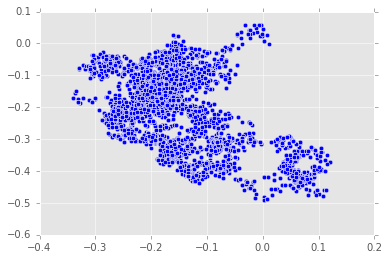

In [152]:
plt.scatter(qmu.params.eval()[:,0,0],qmu.params.eval()[:,0,1])

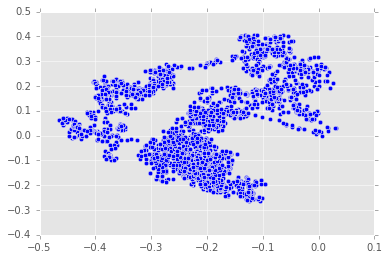

In [153]:
plt.scatter(qmu.params.eval()[:,1,0],qmu.params.eval()[:,1,1])

In [160]:
(tf.reduce_sum(qmu.params,0)).eval()/T

array([[-0.14663024, -0.21510866],
       [-0.2065192 ,  0.04707735]], dtype=float32)

In [159]:
qmu.shape[0]

Dimension(2)

## Kill evil Dirichlet!

In [15]:
# MODEL
#pi = Dirichlet(concentration=tf.constant([1.0] * K))

alpha = Beta(2.0,3.0)
_alpha = alpha.value()

#mu = Normal(loc=tf.zeros([K, D]), scale=tf.ones([K, D]))
mu = Normal(loc=[0.0,0.0], scale =[1.0,1.0], sample_shape=K)
#_mu = mu.value()
#sigma = InverseGamma(concentration=tf.ones([K, D]), rate=tf.ones([K, D]))
sigma = InverseGamma(concentration=[1.0,1.0], rate=[1.0,1.0], sample_shape=K)
#_sigma = sigma.value()
#c = Categorical(logits=tf.tile(tf.reshape(ed.logit(pi), [1, K]), [N, 1]))
#x = Normal(loc=tf.gather(mu, c), scale=tf.gather(sigma, c))


category = Categorical(probs = [_alpha, 1 - _alpha], sample_shape=N)
'''
components = [
    Normal(_mu[k], _sigma[k], sample_shape=N)
    for k in range(K)]
'''
x = Normal(loc=tf.gather(mu, category), scale=tf.gather(sigma, category))

#x = Mixture(cat=category, components=components, sample_shape=N)

In [46]:
# INFERENCE
T = 50000

ialpha = np.ones([T],dtype='float32') / K
imu = np.zeros([T, K, D],dtype='float32')
imu[0,:,:] = np.array([[0.5,0.5],[-0.5,-0.5]])
isigma = np.ones([T, K, D],dtype='float32')
isigma[0,:,:] = np.array([[0.5,0.5],[0.5,0.5]])

qalpha = Empirical(params=tf.Variable(ialpha))
qmu = Empirical(params=tf.Variable(imu))
qsigma = Empirical(params=tf.Variable(isigma))


In [47]:
galpha = Normal(loc = alpha, scale=0.00001)

gmu = Normal(loc=mu,
             scale=tf.constant([0.01,0.01]))
gsigma = Normal(loc = sigma,
                scale = tf.constant([0.001,0.001]))


In [48]:
'''
inference = ed.MetropolisHastings(
    latent_vars   = {alpha: qalpha, mu: qmu, sigma: qsigma},
    proposal_vars = {alpha: galpha, mu: gmu, sigma: gsigma},
    data={x: x_data})
'''

'\ninference = ed.MetropolisHastings(\n    latent_vars   = {alpha: qalpha, mu: qmu, sigma: qsigma},\n    proposal_vars = {alpha: galpha, mu: gmu, sigma: gsigma},\n    data={x: x_data})\n'

In [49]:
inference = ed.Gibbs(
    latent_vars   = {alpha: qalpha, mu: qmu, sigma: qsigma},
    proposal_vars = {alpha: galpha, mu: gmu, sigma: gsigma},
    data={x: x_data})

In [50]:
inference.run()

50000/50000 [100%] ██████████████████████████████ Elapsed: 78s | Acceptance Rate: 1.000


In [51]:
trace = qmu.params.eval()
trace.shape

(50000, 2, 2)

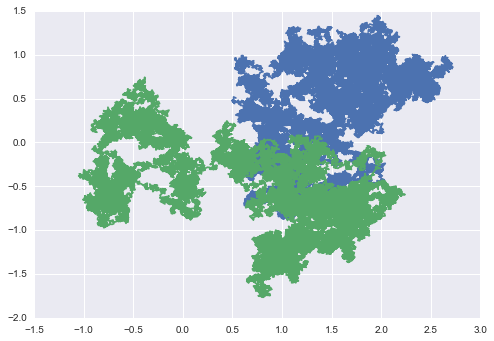

In [52]:
plt.plot(trace[:,0,0],trace[:,0,1])
plt.plot(trace[:,1,0],trace[:,1,1])
plt.show()

In [53]:
half = trace.shape[0] // 2
last = trace.shape[0] // 10

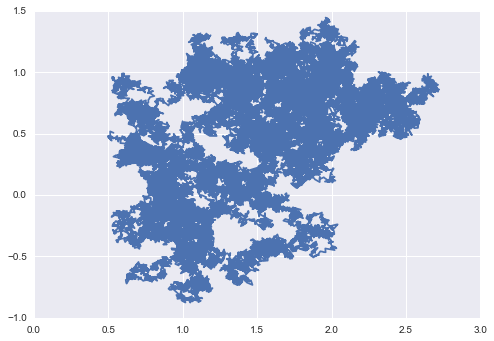

In [54]:
plt.plot(trace[:,0,0],trace[:,0,1])

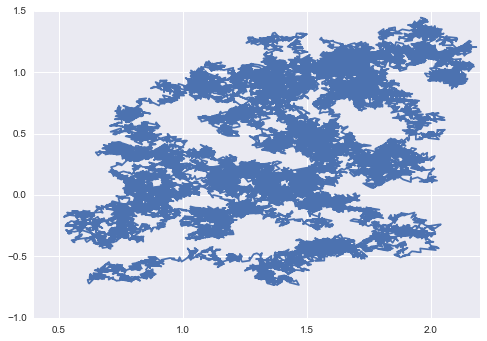

In [55]:
plt.plot(trace[half:,0,0],trace[half:,0,1])

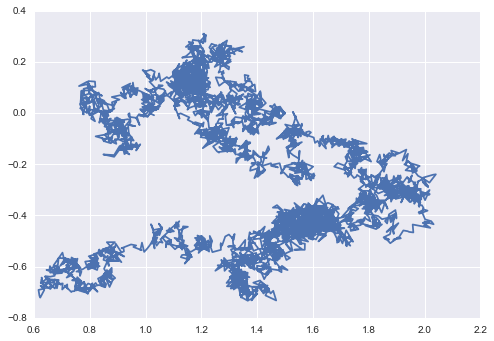

In [56]:
plt.plot(trace[-last:,0,0],trace[-last:,0,1])

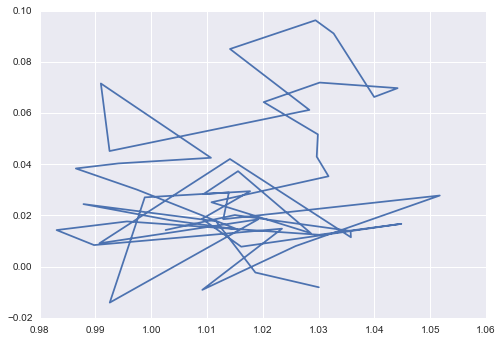

In [57]:
plt.plot(trace[-last:(-last+50),0,0],trace[-last:(-last+50),0,1])

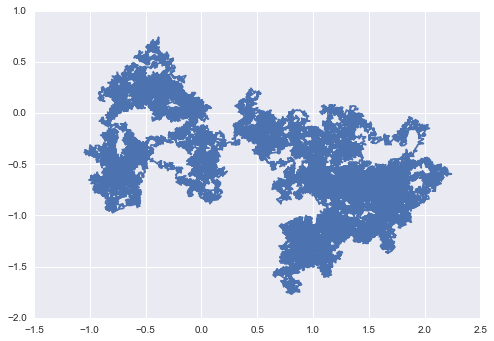

In [58]:
plt.plot(trace[:,1,0],trace[:,1,1])

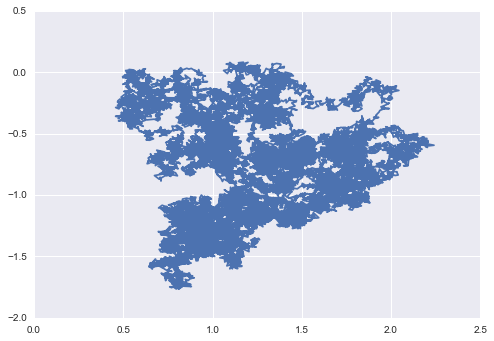

In [59]:
plt.plot(trace[half:,1,0],trace[half:,1,1])

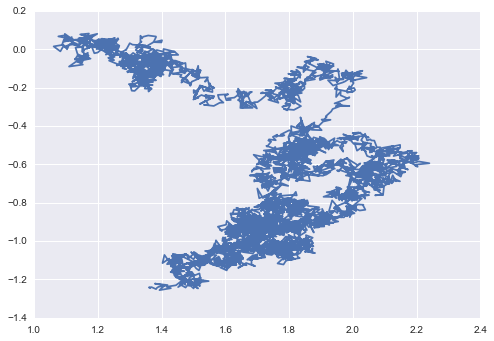

In [60]:
plt.plot(trace[-last:,1,0],trace[-last:,1,1])

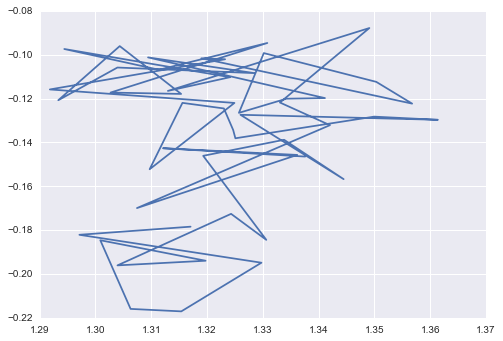

In [61]:
plt.plot(trace[-last:(-last+50),1,0],trace[-last:(-last+50),1,1])

In [31]:
np.mean(trace[-last:,:,:],0)

array([[ 1.113796  ,  0.71790653],
       [-0.95122284, -1.05164754]], dtype=float32)

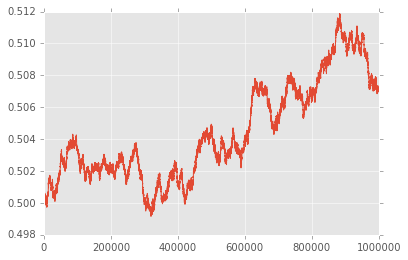

In [63]:
plt.plot(qalpha.params.eval())

In [64]:
np.mean(qalpha.params.eval()[-100:])

0.5071888

In [65]:
qsigma.params.eval().shape

(1000000, 2, 2)

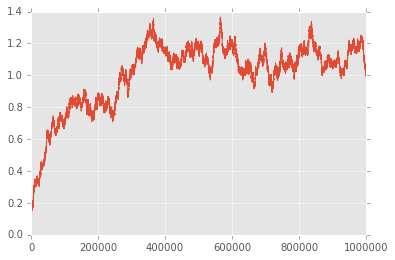

In [66]:
trace = qsigma.params.eval()
plt.plot(trace[:,0,0])

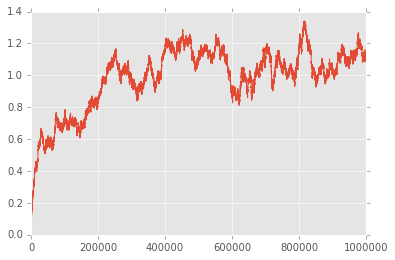

In [67]:
plt.plot(trace[:,0,1])

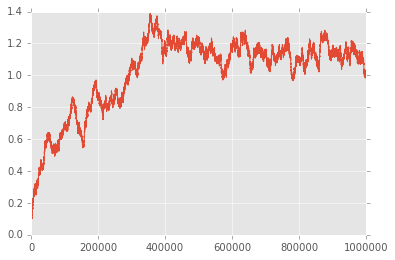

In [68]:
plt.plot(trace[:,1,0])

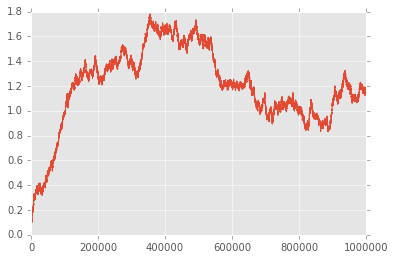

In [69]:
plt.plot(trace[:,1,1])

# MAP

In [31]:
# INFERENCE
from edward.models import PointMass
'''
qp_params = tf.sigmoid(tf.Variable(tf.random_normal([])))
qp = PointMass(params=qp_params)
'''

galpha = Normal(loc = alpha, scale=0.00001)

gmu = Normal(loc=mu,
             scale=tf.constant([0.001,0.001]))
gsigma = Normal(loc = sigma,
                scale = tf.constant([0.001,0.001]))

qalpha_p = tf.Variable(0.5)
qalpha = PointMass(params = qalpha_p)

#qmu_p = tf.Variable([[1.0,1.0],[-1.0,-1.0]])
qmu_p = tf.Variable([[0.25,0.25],[-0.25,-0.25]])
qmu = PointMass(params = qmu_p)

qsigma_p = tf.Variable([[1.0,1.0],[1.0,1.0]])
qsigma = PointMass(params = qsigma_p)

In [32]:
inference = ed.MAP({alpha: qalpha, sigma:qsigma, mu:qmu}, data={x: x_data})


In [33]:
inference.run(n_iter=10000)


10000/10000 [100%] ██████████████████████████████ Elapsed: 6s | Loss: 1447.253


In [34]:
qalpha.eval()

0.33333331

In [35]:
qsigma.eval()

array([[ 1.00576138,  1.03175426],
       [ 1.00622082,  1.03253341]], dtype=float32)

In [36]:
qmu.eval()

array([[-0.22736372, -0.19095199],
       [-0.2287333 , -0.19339478]], dtype=float32)

Fine, let's try Gibbs again..

In [10]:
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture,Empirical

K = 2  # number of components

pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)}, MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat


T = 500  # number of MCMC samples
qpi = Empirical(tf.Variable(tf.ones([T, K]) / K))
qmu = Empirical(tf.Variable(tf.zeros([T, K, D])))
qsigmasq = Empirical(tf.Variable(tf.ones([T, K, D])))
qz = Empirical(tf.Variable(tf.zeros([T, N], dtype=tf.int32)))


inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz}, data={x: x_data})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  t = info_dict['t']
  if t % inference.n_print == 0:
    print("\nInferred cluster means:")
    print(sess.run(running_cluster_means, {t_ph: t - 1}))


  5/500 [  1%]                                ETA: 166s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.19457729 -0.19672109]
 [-0.42825875 -0.72079992]]
 10/500 [  2%]                                ETA: 92s | Acceptance Rate: 1.000 
Inferred cluster means:
[[-0.18667632 -0.19155318]
 [-0.26311582 -0.55455518]]
 15/500 [  3%]                                ETA: 62s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.18859209 -0.19624436]
 [ 0.00555531 -0.4727056 ]]
 20/500 [  4%] █                              ETA: 47s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.19429898 -0.19374456]
 [-0.09063651 -0.12044106]]
 25/500 [  5%] █                              ETA: 38s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.19099458 -0.19215995]
 [ 0.18985231 -0.04231842]]
 30/500 [  6%] █                              ETA: 32s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.18928322 -0.18844414]
 [ 0.17019092 -0.22080863]]
 35/500 [  7%] ██                           

但我们稍微改一下，把它的complete_conditional解出来的共轭分布换成均值恰当的正态分布。不过在那之前我们先看看它共轭分布的形态。

In [63]:
K = 2  # number of components

pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)}, MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat



<ed.RandomVariable 'complete_conditional_Dirichlet_26/cond_dist_2/' shape=(2,) dtype=float32>

In [64]:
ccpi = ed.complete_conditional(pi)
ccpi

<ed.RandomVariable 'complete_conditional_Dirichlet_26/cond_dist_5/' shape=(2,) dtype=float32>

In [66]:
ccpi.sample(5).eval()

array([[ 0.34212127,  0.65787876],
       [ 0.33274853,  0.66725147],
       [ 0.36701459,  0.63298541],
       [ 0.35959783,  0.64040214],
       [ 0.33497411,  0.66502583]], dtype=float32)

In [68]:
ccpi.parameters['concentration'].eval()

array([ 324.,  178.], dtype=float32)

In [70]:
pi.parameters['concentration'].eval()

array([ 1.,  1.], dtype=float32)

In [82]:
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture,Empirical

K = 2  # number of components

pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)}, MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat


T = 5000  # number of MCMC samples
qpi = Empirical(tf.Variable(tf.ones([T, K]) / K))
qmu = Empirical(tf.Variable(tf.zeros([T, K, D])))
qsigmasq = Empirical(tf.Variable(tf.ones([T, K, D])))
qz = Empirical(tf.Variable(tf.zeros([T, N], dtype=tf.int32)))




In [83]:
#galpha = Normal(loc = alpha, scale=0.00001)

gmu = Normal(loc=mu,
             scale=tf.constant([0.01,0.01]))
gsigmasq = Normal(loc = sigmasq,
                scale = tf.constant([0.001,0.001]))


In [84]:
ed.complete_conditional(mu).sample(5).eval()

array([[[ 0.90187204,  0.51076537],
        [ 0.93752503,  0.24122052]],

       [[ 0.89577478,  0.52325243],
        [ 0.93340486,  0.23766059]],

       [[ 0.91986042,  0.49823618],
        [ 0.94451064,  0.27068993]],

       [[ 0.89415681,  0.50337261],
        [ 0.93960637,  0.25190991]],

       [[ 0.87721938,  0.50368214],
        [ 0.92952186,  0.25740236]]], dtype=float32)

In [85]:
gmu.sample(5).eval()

array([[[ 2.67866778,  0.47716594],
        [ 0.45248741, -0.33801126]],

       [[ 2.68092728,  0.49325916],
        [ 0.44737476, -0.34335333]],

       [[ 2.68880844,  0.48380148],
        [ 0.43976152, -0.33066684]],

       [[ 2.68006611,  0.49012581],
        [ 0.44846457, -0.3337878 ]],

       [[ 2.68885303,  0.47749731],
        [ 0.43048012, -0.33269885]]], dtype=float32)

In [86]:
inference = ed.Gibbs({ mu: qmu, sigmasq: qsigmasq},proposal_vars= {mu:gmu, sigmasq:gsigmasq}, data={x: x_data})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  t = info_dict['t']
#if t % inference.n_print == 0:
print("\nInferred cluster means:")
print(sess.run(running_cluster_means, {t_ph: t - 1}))


5000/5000 [100%] ██████████████████████████████ Elapsed: 7s | Acceptance Rate: 1.000

Inferred cluster means:
[[ 0.37940711  0.87449014]
 [ 0.7513482  -0.15074301]]


In [45]:


inference = ed.MAP([pi,mu,sigmasq,z],data={x:x_data})

TypeError: Key-value pair in latent_vars does not have same shape: (2,), ()

In [9]:
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture,Empirical

K = 2  # number of components

pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)}, MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat


T = 500  # number of MCMC samples
qpi = Empirical(tf.Variable(tf.ones([T, K]) / K))
qmu = Empirical(tf.Variable(tf.zeros([T, K, D])))
qsigmasq = Empirical(tf.Variable(tf.ones([T, K, D])))
qz = Empirical(tf.Variable(tf.zeros([T, N], dtype=tf.int32)))


inference = ed.SGLD({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz}, data={x: x_data})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  t = info_dict['t']
  if t % inference.n_print == 0:
    print("\nInferred cluster means:")
    print(sess.run(running_cluster_means, {t_ph: t - 1}))


ValueError: None values not supported.